In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension, model_training
from codes.docs.analysis.gene_analysis import genetic_file_preprocess
from codes.docs.analysis.MLtraining import ML_utils
from codes.docs.analysis import graph_analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re



Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [5]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df_batch2.csv')

In [66]:
df = european_volumetric_dataset_term.copy()
ancestry = [f'euro_Anc_PC{i}' for i in range(1, 4)]
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,
                                                       grouping=None,
                                                       remove_duplicated=True)
dependentVar = [i for i in df.columns if bool(re.search('Imperial \d', i))]
df = data_exploration.MassUnivariate.remove_outliers(
    df,
    col=dependentVar,
    threshold=3,
    remove_schemes='percentage',
    percentage_of_outlier=0.1)
df = df.rename(columns={'AAL 93': 'AAL 109'})
df = df.rename(
    columns={i: i + '_euro_ld_old'
             for i in df.columns if 'PRS' in i})

batch2_euro_ld = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files(
    file_path=
    '../../dataset/PRS/asd/ASD_nodups_euro_batch2_genotyped.gwas.all_score',
    column_prefix='euro_ld_no_dups_gen')
batch2_euro_ld_imputed = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files(
    file_path=
    '../../dataset/PRS/asd/imputed_data/ASD_euro_batch2_imputed.gwas.all.score',
    column_prefix='euro_ld_no_dups_imputed')

df = df.merge(batch2_euro_ld, left_on='ID', right_index=True)
df = df.merge(batch2_euro_ld_imputed, left_on='ID', right_index=True)

####################LABELS#######################
WM_labels = data_preprocessing.Volumes.extract_WM_Imperial(df[[
    i for i in df.columns if bool(re.search('Imperial \d', i))
]]).columns.tolist()
GM_labels = data_preprocessing.Volumes.extract_GM_Imperial(df[[
    i for i in df.columns if bool(re.search('Imperial \d', i))
]]).columns.tolist()
DGM_labels = data_preprocessing.Volumes.extract_deepGM_Imperial(df[[
    i for i in df.columns if bool(re.search('Imperial \d', i))
]]).columns.tolist()
bs_labels = ['Imperial 19']
cerebellum_labels = ['Imperial 17', 'Imperial 18']
ventricle_labels = [f'Imperial {i}' for i in range(49, 51)]
amygdala_label = ['Imperial 3', 'Imperial 4']
lobes = data_preprocessing.Volumes.extract_lobe(
    df[[i for i in df.columns if bool(re.search('Imperial \d', i))]],lobes=['frontal','temporal'])
frontal_lobe = data_preprocessing.Volumes.extract_lobe(
    df[[i for i in df.columns if bool(re.search('Imperial \d', i))]],lobes=['frontal'])
occipital_lobe = data_preprocessing.Volumes.extract_lobe(
    df[[i for i in df.columns if bool(re.search('Imperial \d', i))]],lobes=['occipital'])
parietal_lobe  = data_preprocessing.Volumes.extract_lobe(
    df[[i for i in df.columns if bool(re.search('Imperial \d', i))]],lobes=['parietal'])
temporal_lobe  = data_preprocessing.Volumes.extract_lobe(
    df[[i for i in df.columns if bool(re.search('Imperial \d', i))]],lobes=['temporal'])
# cor_labels = WM_labels+GM_labels+DGM_labels + bs_labels + cerebellum_labels + ventricle_labels
cor_labels = GM_labels + WM_labels
# cor_labels = lobes
# cor_labels = WM_labels
# cor_labels = GM_labels
# cor_labels = GM_labels + WM_labels

## Graph analysis

In [270]:
AAL_cols = [i for i in df.columns if re.search('AAL \d',i)]
Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i) and i in cor_labels]
prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]

_, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
                                                              dependentVar_cols=prs_labels,n_components=1,scaling=True)
df['PRS_pca_euro_ld_no_dups_gen'] = prs_pca

prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]

In [170]:
X = df[['Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol','GA_vol','Gender']+ancestry].values
y = df[Imperial_cols].values

In [176]:
X = df[['GA_vol', 'PMA_vol','17 ICV (all except bone)','Gender']+ancestry].values
y = df[AAL_cols].values


In [209]:
to_permute = df['euro_ld_no_dups_genPt_1'].values
to_permute = prs_pca

In [178]:
result_dict_Imperial = defaultdict(dict)
for prs in prs_labels:
    result_dict_Imperial[prs]['observed_matrix'] = graph_analysis.NBS.Corr_matrix.calculate_adj_corr_matrix(X,y,to_permute=df[prs].values)
    result_dict_Imperial[prs]['permutation_matrices'] = graph_analysis.NBS.Corr_matrix.get_permutation_corr_matrix(X,y,to_permute=df[prs].values,perm=1000)

100%|██████████████████████████████████████| 1000/1000 [00:07<00:00, 132.74it/s]


In [179]:
for prs in prs_labels:
    result_dict_Imperial[prs]['null_distribution']=dict()
    result_dict_Imperial[prs]['observed_metrics'] = dict()
    for threshold in tqdm.tqdm([0.2,0.3,0.4]):
        result_dict_Imperial[prs]['null_distribution'][threshold] = graph_analysis.NBS.get_null_distribution(result_dict_Imperial[prs]['permutation_matrices'],
                                                             threshold=threshold,
                                                            metrics = ['max_edge_size',
                                                                      'max_degree_centrality'])
        result_dict_Imperial[prs]['observed_metrics'][threshold] = graph_analysis.NBS.get_p_val(result_dict_Imperial[prs]['observed_matrix'] ,threshold=threshold,null_distribution=result_dict_Imperial[prs]['null_distribution'][threshold])

100%|█████████████████████████████████████████████| 3/3 [00:27<00:00,  9.15s/it]


In [180]:
result_dict_Imperial.keys()

dict_keys(['euro_ld_no_dups_genPt_1e-08', 'euro_ld_no_dups_genPt_1e-07', 'euro_ld_no_dups_genPt_1e-06', 'euro_ld_no_dups_genPt_1e-05', 'euro_ld_no_dups_genPt_0.0001', 'euro_ld_no_dups_genPt_0.001', 'euro_ld_no_dups_genPt_0.01', 'euro_ld_no_dups_genPt_0.05', 'euro_ld_no_dups_genPt_0.1', 'euro_ld_no_dups_genPt_0.5', 'euro_ld_no_dups_genPt_1', 'PRS_pca_euro_ld_no_dups_gen'])

In [183]:
result_dict_Imperial['PRS_pca_euro_ld_no_dups_gen']['observed_metrics']

{0.2: defaultdict(dict,
             {'max_edge_size': {'p_vals': array([0.628]),
               'comps': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                      1, 1, 1, 1, 1]),
               'ind_sz': array([1]),
               'sz_links': array([360.])},
              'max_degree_centrality': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 0.762, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                      1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,

In [181]:
[v['observed_metrics'] for k,v in result_dict_Imperial.items()]

[{0.2: defaultdict(dict,
              {'max_edge_size': {'p_vals': array([0.811]),
                'comps': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                       1, 1, 1, 1, 1]),
                'ind_sz': array([1]),
                'sz_links': array([358.])},
               'max_degree_centrality': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 0.999, 0.749, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
                       1.   , 1.   , 1.   , 1.   ,

In [216]:
observed_matrix = graph_analysis.NBS.Corr_matrix.calculate_adj_corr_matrix(X,y,to_permute=to_permute)

In [217]:
permutation_matrices = graph_analysis.NBS.Corr_matrix.get_permutation_corr_matrix(X,y,to_permute=to_permute,perm=1000)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 154.17it/s]


In [218]:
threshold = 0.3
null_distribution = graph_analysis.NBS.get_null_distribution(permutation_matrices,
                                                             threshold=threshold,
                                                            metrics = ['max_edge_size',
                                                                      'max_degree_centrality'])

In [219]:
observed_metrics = graph_analysis.NBS.get_p_val(observed_matrix,threshold=threshold,null_distribution=null_distribution)

In [165]:
observed_square = graph_analysis.Graph_analysis.reverse_lower_triangle(observed_matrix)

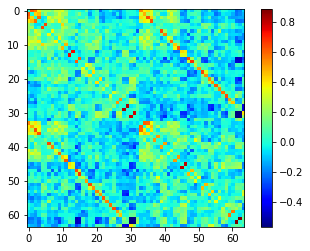

In [166]:
plt.imshow(observed_square,cmap='jet')
plt.colorbar()

In [220]:
observed_metrics

defaultdict(dict,
            {'max_edge_size': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.923,
                     1.   , 1.   , 1.   , 1.   ]),
              'comps': array([ 1,  1,  3,  3,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2, 12, 12, 11,
                     11,  3,  3, 12, 12,  3,  3,  4,  4,  4,  4, 10, 10, 12, 12, 12, 12,
                      5,  5, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,
                      8,  8,  6,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
                      9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 13,
                     13, 12, 12, 13, 13, 14, 14, 14]),
              'ind_sz': array([ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14]),
              'sz_links': array([ 1.,  4.,  6., 21.,  1.,  1., 38.,  1., 48.,  5., 16.,  3.,  3.])},
             'max_degree_centrality': {'p_vals': array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
      

## Feature selection analysis

In [296]:
AAL_cols = [i for i in df.columns if re.search('AAL \d',i)]
Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i) and i in cor_labels]
prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]
prs_label = 'euro_ld_no_dups_genPt_1'



_, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
                                                              dependentVar_cols=prs_labels,n_components=.80)


In [240]:
from sklearn.linear_model import RidgeCV,Ridge,Lasso,LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector, RFE,RFECV

In [235]:
adjusted_df = df.copy()
adjusted_df[
    Imperial_cols] = data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
        df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol',
            'GA_vol'
        ],
        dependentVar_cols=Imperial_cols)

adjusted_df[prs_label] =data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
        df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=[prs_label])

In [238]:
train,test = train_test_split(df,test_size=.2)

In [250]:
const_train=np.ones((len(train),1))
const_test = np.ones((len(test),1))
X_train = np.empty((len(train),len(Imperial_cols)))
X_test = np.empty((len(test),len(Imperial_cols)))
for idx,col in enumerate(Imperial_cols):
    adjust_volumes = LinearRegression()
    temp_X_train = np.concatenate([const_train,train[['Gender','Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol','GA_vol']].values],axis=1)
    temp_X_test = np.concatenate([const_test,test[['Gender','Total_Brain_Volume_Imperial', 'Intracranial_Imperial', 'PMA_vol','GA_vol']].values],axis=1)
    adjust_volumes.fit(temp_X_train,train[col].values)
    X_train[:,idx] = train[col].values - adjust_volumes.predict(temp_X_train)
    X_test[:,idx] = test[col].values - adjust_volumes.predict(temp_X_test)

y_train = np.empty((len(train),len(prs_labels)))
y_test = np.empty((len(test),len(prs_labels)))
for idx,col in enumerate(prs_labels):
    adjust_volumes = LinearRegression()
    temp_X_train = np.concatenate([const_train,train[ancestry].values],axis=1)
    temp_X_test = np.concatenate([const_test,test[ancestry].values],axis=1)
    adjust_volumes.fit(temp_X_train,train[col].values)
    y_train[:,idx] = train[col].values - adjust_volumes.predict(temp_X_train)
    y_test[:,idx] = test[col].values - adjust_volumes.predict(temp_X_test)


In [254]:
y_train = y_train[:,np.array(prs_labels)==prs_label].reshape(-1)
y_test = y_test[:,np.array(prs_labels)==prs_label].reshape(-1)

In [266]:
model = Ridge()
selector = RFECV(model,step=1,scoring='neg_mean_squared_error')

In [267]:
selector.fit(X_train,y_train)

RFECV(estimator=Ridge(), scoring='neg_mean_squared_error')

In [282]:
np.array(Imperial_cols)[selector.support_]

array(['Imperial 13'], dtype='<U11')

In [269]:
selector.ranking_

array([ 7,  3,  8, 36, 31, 30, 41, 44,  1, 40, 12, 51, 56, 38, 42, 43, 13,
       37, 21, 32, 35, 58, 16,  9, 27, 15, 18, 55, 46, 47, 53, 52, 29,  6,
        2,  5, 28, 19, 26, 50, 61, 63, 64, 24, 14,  4, 39, 62, 60, 25, 20,
       22, 33, 45, 23, 17, 34, 11, 10, 65, 54, 57, 59, 49, 48])

In [291]:
np.sqrt(-selector.cv_results_['mean_test_score'].mean())

3.8533414611487746e-05

In [293]:
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
np.sqrt(mean_squared_error(y_test,selector.predict(X_test)))
r2_score(y_test,selector.predict(X_test))

explained_variance_score(y_test,selector.predict(X_test))

-0.03225340366953122

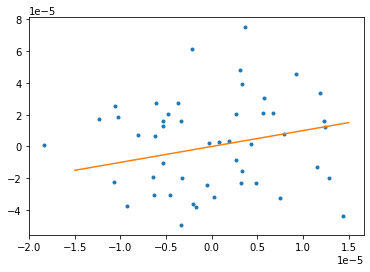

In [287]:
plt.plot(selector.predict(X_test),y_test,'.')
plt.plot([-1.5e-5,1.5e-5],[-1.5e-5,1.5e-5])

In [280]:
selector.estimator_

Ridge()

1

In [73]:
np.array(Imperial_cols)[np.argsort(selector.ranking_)[:10]]

array(['Imperial 6', 'Imperial 76', 'Imperial 33', 'Imperial 52',
       'Imperial 75', 'Imperial 63', 'Imperial 32', 'Imperial 57',
       'Imperial 13', 'Imperial 48'], dtype='<U11')

In [74]:
selector.cv_results_

{'mean_test_score': array([-2.73897071e-05, -2.75359511e-05, -2.71245745e-05, -2.70897528e-05,
        -2.71522744e-05, -2.72782677e-05, -2.76519665e-05, -2.76263463e-05,
        -2.76529235e-05, -2.77654501e-05, -2.81609430e-05, -2.82416240e-05,
        -2.79277240e-05, -2.79827474e-05, -2.83961358e-05, -2.87214761e-05,
        -2.87138143e-05, -2.87213633e-05, -2.86501768e-05, -2.86491197e-05,
        -2.90227013e-05, -2.94905794e-05, -2.98312164e-05, -3.01367076e-05,
        -3.01909114e-05, -3.06799866e-05, -3.11388734e-05, -3.11389232e-05,
        -3.12220399e-05, -3.16617967e-05, -3.16478917e-05, -3.15850363e-05,
        -3.13146197e-05, -3.13246641e-05, -3.09798912e-05, -3.11162207e-05,
        -3.10310163e-05, -3.10057059e-05, -3.09788277e-05, -3.10374095e-05,
        -3.11010593e-05, -3.10963178e-05, -3.11197399e-05]),
 'std_test_score': array([2.94838524e-06, 2.21102316e-06, 2.33766726e-06, 2.12462210e-06,
        2.38053260e-06, 2.25757519e-06, 2.27401320e-06, 2.45213428e-06

array([15,  2, 42, 31, 16, 13,  9, 25, 19, 38, 35, 22, 24, 23, 20, 39,  7,
        3, 34, 30, 17, 40, 10, 28,  1, 27, 41,  8, 33, 12, 43, 11, 18,  6,
       14, 32, 29,  5,  4, 37, 26, 36, 21])

In [33]:
np.array(Imperial_cols)[selector.ranki]

array(['Imperial 52'], dtype='<U11')

In [22]:
sfs_foward = SequentialFeatureSelector(ridge,n_features_to_select=5,direction='forward').fit(X_train,y_train)
sfs_backward = SequentialFeatureSelector(ridge,n_features_to_select=5,direction='backward').fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
np.array(Imperial_cols)[sfs_foward.get_support()]

In [ ]:
np.array(Imperial_cols)[sfs_backward.get_support()]

In [125]:
train_mass_univariates = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = train,
                                                                                     thresholds = prs,
                                                                                     cont_independentVar_cols=pipe.named_steps['pca'].covariates,
                                                                                     dependentVar_cols=pipe.named_steps['pca'].X_pca
                                                                                    )

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 38.56it/s]


In [136]:
train_mass_univariates.sort_values(by='PRS_pval').head(15)

,Connection,const_coef,const_pval,Cont_0_coef,Cont_0_pval,Cont_1_coef,Cont_1_pval,Cont_2_coef,Cont_2_pval,Cont_3_coef,Cont_3_pval,Cont_4_coef,Cont_4_pval,Cont_5_coef,Cont_5_pval,Cont_6_coef,Cont_6_pval,PRS_coef,PRS_pval,threshold
31,Dependent_Var_3,4.163336e-17,1.0,-0.007071,0.950941,-0.673064,0.000123,0.459295,0.001449,0.050404,0.567462,-0.030248,0.730523,-0.045564,0.600335,-0.053707,0.583459,0.304079,0.000967,PRS_0.0001_ASD_Euro_LD
10,Dependent_Var_3,4.163336e-17,1.0,-0.019495,0.866336,-0.666199,0.000169,0.465640,0.001360,0.060998,0.493531,-0.037367,0.673385,-0.043974,0.616109,-0.108168,0.262332,0.256539,0.004274,PRS_1e-07_ASD_Euro_LD
45,Dependent_Var_3,4.163336e-17,1.0,0.016351,0.888600,-0.750845,0.000023,0.505542,0.000511,0.069672,0.437615,-0.055434,0.536561,-0.037905,0.666060,-0.095832,0.324548,0.240697,0.007867,PRS_0.01_ASD_Euro_LD
38,Dependent_Var_3,4.163336e-17,1.0,-0.001030,0.992967,-0.701960,0.000078,0.501037,0.000603,0.059882,0.505027,-0.044720,0.618079,-0.031998,0.716418,-0.107215,0.270853,0.213316,0.018306,PRS_0.001_ASD_Euro_LD
3,Dependent_Var_3,4.163336e-17,1.0,-0.037242,0.750468,-0.686086,0.000118,0.481925,0.000984,0.051910,0.562290,-0.031316,0.725638,-0.035335,0.688680,-0.114128,0.240209,0.208930,0.018497,PRS_1e-08_ASD_Euro_LD
52,Dependent_Var_3,4.163336e-17,1.0,0.002329,0.984112,-0.735570,0.000035,0.495586,0.000697,0.064580,0.473631,-0.042035,0.639160,-0.024548,0.780295,-0.103130,0.290769,0.206765,0.020884,PRS_0.05_ASD_Euro_LD
59,Dependent_Var_3,4.163336e-17,1.0,-0.009149,0.937749,-0.729731,0.000043,0.499550,0.000656,0.062302,0.490822,-0.045897,0.611225,-0.024209,0.783933,-0.113737,0.243954,0.183740,0.039918,PRS_0.1_ASD_Euro_LD
43,Dependent_Var_1,-4.163336e-17,1.0,-0.052444,0.731072,-0.120534,0.593733,-0.029258,0.875581,-0.013044,0.911390,0.058819,0.615796,-0.296358,0.010524,-0.241742,0.058193,0.207980,0.077224,PRS_0.01_ASD_Euro_LD
66,Dependent_Var_3,4.163336e-17,1.0,-0.022424,0.848815,-0.728276,0.000047,0.493401,0.000803,0.065268,0.474296,-0.034171,0.704472,-0.020422,0.817622,-0.113534,0.246949,0.156550,0.081996,PRS_0.5_ASD_Euro_LD
61,Dependent_Var_5,2.602085e-17,1.0,0.275211,0.008642,-0.572486,0.000270,0.284930,0.026745,0.021991,0.783550,-0.081214,0.310451,0.214113,0.006744,-0.174052,0.044946,-0.133502,0.091308,PRS_0.1_ASD_Euro_LD


In [127]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

<AxesSubplot:>

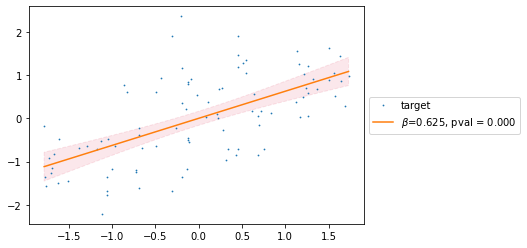

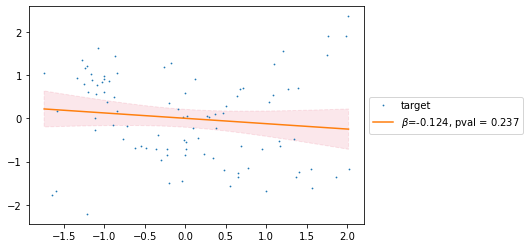

In [138]:
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Y'],pipe.named_steps['pca'].pca.components_[3])
visualisation.plot_Linear_Reg(ROIs_coord.loc[0:92,'Z'],pipe.named_steps['pca'].pca.components_[3])

In [129]:
dependentVar_test,independentVar_test = data_exploration.MassUnivariate.prepare_data(df = test,
                                                                           cat_independentVar_cols=['Gender'],
                                                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                                                          dependentVar_cols=prs)
independentVar_test = independentVar_test.drop(columns='const')

In [130]:
new_X_pca = pipe.transform(independentVar_test.to_numpy())

In [131]:
new_X_pca.shape

(21, 14)

In [132]:
test_mass_univariates = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = test,
                                                                                     thresholds = prs,
                                                                                     cont_independentVar_cols=new_X_pca[:,7:],
                                                                                     dependentVar_cols=new_X_pca[:,3]
                                                                                    )

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 82.56it/s]


In [133]:
test_mass_univariates.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,Cont_0_coef,Cont_0_pval,Cont_1_coef,Cont_1_pval,Cont_2_coef,Cont_2_pval,Cont_3_coef,Cont_3_pval,Cont_4_coef,Cont_4_pval,Cont_5_coef,Cont_5_pval,Cont_6_coef,Cont_6_pval,PRS_coef,PRS_pval,threshold
6,Dependent_Var_0,6.938894e-17,1.0,0.207373,0.392733,-1.263748,0.000472,0.849706,0.002301,-0.261191,0.163556,-0.076459,0.720536,0.063061,0.775338,0.196918,0.363149,0.544377,0.004153,PRS_0.01_ASD_Euro_LD
10,Dependent_Var_0,6.938894e-17,1.0,0.407020,0.171448,-1.418432,0.000859,0.852866,0.006216,-0.024144,0.903957,-0.296093,0.244549,-0.048681,0.847912,0.061373,0.802934,0.443688,0.031426,PRS_1_ASD_Euro_LD
7,Dependent_Var_0,6.938894e-17,1.0,0.367889,0.218480,-1.220289,0.002321,0.804518,0.010309,-0.098064,0.632784,-0.165300,0.514075,-0.011790,0.963917,0.103354,0.681719,0.401646,0.042467,PRS_0.05_ASD_Euro_LD
9,Dependent_Var_0,6.938894e-17,1.0,0.395233,0.195790,-1.394667,0.001204,0.855472,0.007362,-0.002225,0.991453,-0.264140,0.308171,-0.059872,0.819100,0.087220,0.731126,0.412357,0.047934,PRS_0.5_ASD_Euro_LD
2,Dependent_Var_0,6.938894e-17,1.0,0.238514,0.430819,-1.124591,0.005753,0.700398,0.032592,-0.051550,0.809707,-0.127382,0.634090,-0.044562,0.870033,0.053234,0.840146,0.351883,0.082351,PRS_1e-06_ASD_Euro_LD
8,Dependent_Var_0,6.938894e-17,1.0,0.339617,0.274799,-1.185744,0.003975,0.732134,0.025127,-0.093956,0.663101,-0.221971,0.405837,0.061418,0.827934,0.110873,0.676050,0.383952,0.085721,PRS_0.1_ASD_Euro_LD
3,Dependent_Var_0,6.938894e-17,1.0,0.180892,0.560221,-1.512914,0.001959,0.921208,0.007025,-0.175521,0.446799,-0.086878,0.755481,0.126743,0.676174,0.178732,0.519268,0.443061,0.112513,PRS_1e-05_ASD_Euro_LD
0,Dependent_Var_0,6.938894e-17,1.0,0.143920,0.654729,-1.031205,0.015540,0.680276,0.050900,0.003135,0.989024,-0.068164,0.814770,-0.050757,0.858303,0.075835,0.782912,0.320943,0.154550,PRS_1e-08_ASD_Euro_LD
4,Dependent_Var_0,6.938894e-17,1.0,0.267815,0.409061,-1.561028,0.004733,1.056085,0.007671,-0.163544,0.502500,-0.235461,0.409311,-0.093117,0.749649,0.092163,0.744075,0.359970,0.226935,PRS_0.0001_ASD_Euro_LD
5,Dependent_Var_0,6.938894e-17,1.0,0.320813,0.334084,-1.381903,0.003684,0.969776,0.008395,-0.163878,0.504895,-0.294897,0.319344,-0.119566,0.685713,0.002606,0.992845,0.259370,0.242410,PRS_0.001_ASD_Euro_LD


In [61]:
pipe.named_steps['pca'].X_pca.shape

(102, 5)

In [34]:
pca_scaler.covariates.shape[1]

7

In [25]:
data_exploration.MassUnivariate.mass_univariate(cont_independentVar_cols=pca_scaler.covariates,
                                               dependentVar_cols=pca_scaler.X_pca)

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7faefdb45550>,
                    const_coef  const_pval  Cont_0_coef  Cont_0_pval  \
 Dependent_Var_0  2.220446e-16         1.0    -0.233361     0.099901   
 Dependent_Var_1  1.040834e-16         1.0     0.290522     0.220988   
 Dependent_Var_2  6.938894e-17         1.0    -0.341171     0.091035   
 Dependent_Var_3 -1.387779e-17         1.0     0.020836     0.912247   
 Dependent_Var_4 -1.249001e-16         1.0    -0.159459     0.320879   
 
                  Cont_1_coef  Cont_1_pval  Cont_2_coef   Cont_2_pval  \
 Dependent_Var_0     0.399012     0.062150     7.928177  1.491566e-66   
 Dependent_Var_1    -0.254000     0.475966     0.206976  4.728614e-01   
 Dependent_Var_2     1.039196     0.000826    -0.687578  5.765722e-03   
 Dependent_Var_3     0.431477     0.131788    -0.359228  1.211080e-01   
 Dependent_Var_4     0.875618     0.000445    -0.500562  1.167368e-02   
 
                  Cont_3_coef  Cont_3_pval 

In [23]:
set1_mass_univariates

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
0,Dependent_Var_0,0.152570,0.288985,-0.216932,0.131803,0.377604,0.081003,7.943010,9.347067e-66,-0.007850,0.935334,-0.137436,0.171437,-0.014972,0.878718,-0.070035,0.478189,-0.317594,0.157282,PRS_1e-08_ASD_Euro_LD
1,Dependent_Var_1,-0.278160,0.248116,0.248323,0.300874,-0.199012,0.579709,0.168877,5.603793e-01,0.026084,0.871979,-0.004682,0.977671,0.215181,0.191896,0.179887,0.277075,0.579028,0.123620,PRS_1e-08_ASD_Euro_LD
2,Dependent_Var_2,0.105864,0.600372,-0.289549,0.152769,0.971929,0.001736,-0.640971,9.832760e-03,0.034120,0.802218,-0.007666,0.956567,0.284371,0.041751,-0.220059,0.115347,-0.220369,0.483945,PRS_1e-08_ASD_Euro_LD
3,Dependent_Var_3,0.033484,0.861885,0.045928,0.810911,0.398780,0.168258,-0.336574,1.497850e-01,0.004802,0.970490,-0.064912,0.628671,0.360057,0.007308,-0.106965,0.419628,-0.069702,0.816088,PRS_1e-08_ASD_Euro_LD
4,Dependent_Var_4,-0.188967,0.245901,-0.126242,0.436076,0.832334,0.000879,-0.470571,1.799924e-02,0.101113,0.356630,0.133014,0.241301,-0.218337,0.051501,-0.141602,0.206242,0.393360,0.121875,PRS_1e-08_ASD_Euro_LD
5,Dependent_Var_0,0.161961,0.261886,-0.209781,0.144980,0.353572,0.106489,7.955466,1.239201e-65,-0.010254,0.915376,-0.125937,0.212454,-0.006227,0.949782,-0.096970,0.348102,-0.337143,0.136143,PRS_1e-07_ASD_Euro_LD
6,Dependent_Var_1,-0.274804,0.258597,0.270301,0.263916,-0.215033,0.557744,0.183575,5.317293e-01,0.032242,0.842827,-0.013852,0.934858,0.220705,0.187297,0.083156,0.632392,0.572040,0.133465,PRS_1e-07_ASD_Euro_LD
7,Dependent_Var_2,0.124489,0.539581,-0.283058,0.162634,0.927209,0.003134,-0.620325,1.286796e-02,0.026573,0.845074,0.020400,0.885561,0.300766,0.032975,-0.238983,0.102455,-0.259141,0.414303,PRS_1e-07_ASD_Euro_LD
8,Dependent_Var_3,0.037460,0.846660,0.041628,0.828964,0.391409,0.183429,-0.335167,1.548270e-01,0.001137,0.993019,-0.055033,0.684577,0.362854,0.007505,-0.085504,0.538325,-0.077978,0.796773,PRS_1e-07_ASD_Euro_LD
9,Dependent_Var_4,-0.166501,0.303747,-0.106676,0.507002,0.773902,0.002005,-0.439478,2.637980e-02,0.096251,0.375068,0.158841,0.161533,-0.197112,0.078095,-0.217064,0.063069,0.346593,0.171733,PRS_1e-07_ASD_Euro_LD


In [55]:
model_summary = model_training.NestedCV.perform_nestedcv(
    pipe,df = df,bins=2,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+columns_names,
                                          dependentVar_cols=prs,n_splits=3,scoring='r2')

In [56]:
pd.DataFrame({i:[model_summary[i][split]['test_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,-0.203171,-0.005448,-0.052502
PRS_1e-07_ASD_Euro_LD,-0.068232,0.057059,-0.049456
PRS_1e-06_ASD_Euro_LD,-0.287125,0.070573,-0.024034
PRS_1e-05_ASD_Euro_LD,-0.005510,-0.003562,-0.164821
PRS_0.0001_ASD_Euro_LD,0.026407,0.045557,-0.108104
PRS_0.001_ASD_Euro_LD,0.030127,0.053427,-0.042215
PRS_0.01_ASD_Euro_LD,0.042415,-0.120966,0.114993
PRS_0.05_ASD_Euro_LD,0.045222,-0.104087,-0.084327
PRS_0.1_ASD_Euro_LD,0.049147,-0.120371,-0.192523
PRS_0.5_ASD_Euro_LD,0.026935,-0.175751,-0.280489


In [ ]:
lin_reg

In [101]:
pd.DataFrame({i:[model_summary[i][split]['cv_r2_score'] for split in model_summary[i].keys()] for i in prs}).T

,0,1,2
PRS_1e-08_ASD_Euro_LD,"[0.020470588159416603, -0.030608108131903622, ...","[0.0035446024944549848, -0.03205312493637047, ...","[-0.0933690340822182, 0.021245454512250905, -0..."
PRS_1e-07_ASD_Euro_LD,"[0.028622948109082613, -0.11943668589158052, -...","[0.08869516524974885, 0.033538265270392054, -0...","[-0.1969097433667275, 0.12649983344128812, 0.0..."
PRS_1e-06_ASD_Euro_LD,"[-0.021763730344513066, -0.17889472312135668, ...","[-0.03485112592143613, 0.017695333549868297, -...","[-0.14582677552988166, 0.015913836765960254, -..."
PRS_1e-05_ASD_Euro_LD,"[-0.009747745672150199, -0.04758339578897641, ...","[0.06831726508310632, -0.015003485302910402, -...","[0.0646333089211042, 0.1115732199981182, -0.04..."
PRS_0.0001_ASD_Euro_LD,"[0.09368072487900514, 0.002127412801282369, -0...","[0.1684213043381918, -0.002749219741268183, -0...","[-0.2031405275681526, -0.04403843196028623, 0...."
PRS_0.001_ASD_Euro_LD,"[-0.09429761555810168, 0.07971829508553163, -0...","[-0.13350516026505566, -0.05526365805027744, -...","[-0.005012461888782349, 0.01791844643788132, -..."
PRS_0.01_ASD_Euro_LD,"[-0.06081412484963322, 0.017845013759780537, 0...","[0.020432791360621705, 0.0757909214228285, 0.0...","[-0.021906400602517584, -0.038764601825013845,..."
PRS_0.05_ASD_Euro_LD,"[0.03310251333810721, -0.004245412567063456, -...","[0.03748706675055047, 0.03864127283238905, 0.0...","[-0.17642315882763682, -0.1361204049885092, 0...."
PRS_0.1_ASD_Euro_LD,"[-0.061234689842185164, -0.17364594983998272, ...","[0.05087274736022296, 0.022822956908664427, -0...","[-0.09858408655429107, 0.05522984993080826, 0...."
PRS_0.5_ASD_Euro_LD,"[-0.15386737625798852, -0.1626773873861802, 0....","[-0.022357712837534294, 0.02508059562831022, -...","[0.0444335624837503, -0.12138032232283424, -0...."


In [110]:
prs_ = 'PRS_0.01_ASD_Euro_LD'
y_test_pred_dict = {i:{'y_pred':model_summary[prs_][i]['y_pred'],
   'y_test':model_summary[prs_][i]['y_test'],'split':[i for n in range(len(model_summary[prs_][i]['y_test']))]} for i in model_summary[prs_].keys()}

In [111]:
y_test_pred_dict = pd.concat([pd.DataFrame(y_test_pred_dict[i]) for i in y_test_pred_dict.keys()])

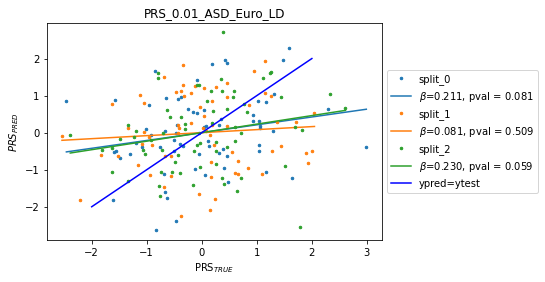

In [112]:
ax = visualisation.plot_Linear_Reg(data = y_test_pred_dict, x = 'y_test', y = 'y_pred',markersize=5,scaling='both',hue='split',hide_CI=True,xlabel=r'PRS$_{TRUE}$',ylabel=r'$PRS_{PRED}$',title=f'{prs_}')
ax.plot([-2,2],[-2,2],'b-',label='ypred=ytest')
ax.legend(loc='center left',bbox_to_anchor=(1,0.5))

In [104]:
lin_reg = LinearRegression()

In [72]:
y,X = data_exploration.MassUnivariate.prepare_data(df = df,
                                          cat_independentVar_cols=['Gender'],
                                          cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry+dependentVar,
                                                  dependentVar_cols=prs)

,const,GA_vol,PMA_vol,17 ICV (all except bone),euro_Anc_PC1,euro_Anc_PC2,euro_Anc_PC3,AAL 1,AAL 2,AAL 3,...,AAL 85,AAL 86,AAL 87,AAL 88,AAL 89,AAL 90,AAL 91,AAL 92,AAL 109,Gender_2.0
0,1.0,-0.867947,0.308270,1.838078,0.707933,0.072990,0.254428,1.037355,0.720263,1.954052,...,1.494046,2.006972,1.142841,1.242644,1.554399,1.874374,1.161712,1.020085,0.765372,0
1,1.0,-0.296195,0.308270,0.785095,-1.895899,0.408387,-2.257130,1.201847,0.931634,1.279001,...,0.124951,0.326012,0.776416,-0.109148,0.737017,0.062129,0.499356,0.639860,0.064510,0
2,1.0,-0.867947,0.811151,0.894440,-2.378463,-2.017302,-0.191470,1.129626,1.306049,0.556969,...,0.305463,1.077255,2.002414,1.625938,0.837295,0.612762,1.318961,0.958324,2.131004,0
3,1.0,1.190359,0.811151,1.607367,0.696581,0.640625,-1.137209,1.746550,1.301531,1.158332,...,1.690517,1.031688,0.422968,0.433344,1.595844,1.629106,1.593206,1.246643,1.860469,0
4,1.0,1.533410,1.062591,1.384905,1.023702,-0.120918,-0.394134,1.703406,0.999604,1.326147,...,1.333297,0.827409,-0.571724,-0.073647,0.949096,0.924231,0.928284,0.800947,1.262021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1.0,0.504257,-0.278424,-0.785043,0.314708,0.218152,1.565692,-0.812053,-0.615507,-0.895339,...,-0.565591,-0.778999,-0.858757,0.011776,-0.364415,-0.862511,-0.765616,-0.708282,-0.418876,0
201,1.0,1.419060,0.308270,-0.177393,0.893955,-0.578483,0.056851,-0.556549,-0.386908,-0.229354,...,0.386582,0.208916,-0.449582,-0.822486,-0.300125,-0.314727,0.269697,0.363599,0.225227,1
202,1.0,-1.897100,0.643524,0.018181,0.711032,-0.018205,0.894654,0.160938,0.394489,-0.327604,...,-0.548970,0.320820,-0.406069,0.001237,0.430929,-0.194806,-0.148887,0.172752,-0.037288,1
203,1.0,0.847308,0.643524,0.690544,0.130952,-1.068898,0.989428,0.633420,1.031961,0.811328,...,0.791183,0.764715,0.519155,0.432789,0.680005,0.534352,0.864534,1.091121,0.679923,1


## Clustering

### AAL atlas

In [20]:
AAL_cols = [i for i in df.columns if re.search('AAL \d',i)]
Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i) and i in cor_labels]
prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]


_, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
                                                              dependentVar_cols=prs_labels,n_components=1,scaling=True)
pca, X_pca, brain_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=AAL_cols,
    scaling=True,n_components = .8)

df['Brain_PC5'] = X_pca[:,4]
df['PRS_pca'] = prs_pca

In [21]:
prs_loading_matrix = df[[f'AAL {i}' for i in list(range(1, 93)) + [109]]].apply(
    lambda x: np.corrcoef(x.values, df['PRS_pca'].values)[0, 1],
    axis=0)

brain_loading_matrix = df[[f'AAL {i}' for i in list(range(1, 93)) + [109]]].apply(
    lambda x: np.corrcoef(x.values, df['Brain_PC5'])[0, 1],
    axis=0)

In [22]:
ROIs_coord_AAL = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')
standardized_ROIs_coord = ROIs_coord_AAL.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(ROIs_coord_AAL[['X','Y','Z']])
standardized_ROIs_coord['Label'] = [f'AAL {int(i)}' for i in standardized_ROIs_coord['Label']]

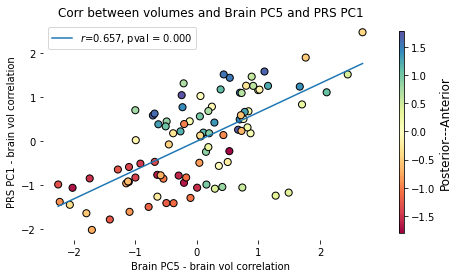

In [24]:
visualisation.simple_plots.Scatter(x=prs_loading_matrix,
                                   y=brain_loading_matrix,
                                   colorby=standardized_ROIs_coord.set_index('Label').loc[prs_loading_matrix.index,'Y'],
                                  markersize=50,legend_loc='upper left',colorbar_label='Posterior---Anterior',
                                  cmap='Spectral',hide_CI=True,title='Corr between volumes and Brain PC5 and PRS PC1',
                                  xlabel='Brain PC5 - brain vol correlation',
                                  ylabel='PRS PC1 - brain vol correlation',scaling='both',edgecolors='k')
sns.despine(bottom=True,left=True)

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [39]:
corr_matrices = np.concatenate([prs_loading_matrix.values.reshape(-1,1),
               brain_loading_matrix.values.reshape(-1,1)],axis=1)

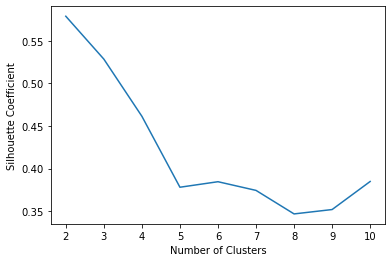

In [40]:
kmeans_kwargs= {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":42
}
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(corr_matrices)
    score = silhouette_score(corr_matrices, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score


plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [41]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(corr_matrices)

KMeans(init='random', n_clusters=2, random_state=42)

In [42]:
kmeans_clusters = pd.DataFrame({'PRS-cor':prs_loading_matrix,
            'Brain-cor':brain_loading_matrix,
             'cluster':kmeans.predict(corr_matrices)})

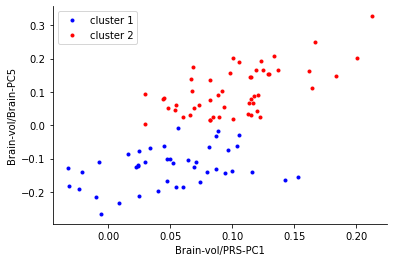

In [43]:
ax = plt.subplot(111)
ax.plot(kmeans_clusters.loc[kmeans_clusters['cluster']==0,'PRS-cor'],
        kmeans_clusters.loc[kmeans_clusters['cluster']==0,'Brain-cor'],'b.',label='cluster 1')
ax.plot(kmeans_clusters.loc[kmeans_clusters['cluster']==1,'PRS-cor'],
        kmeans_clusters.loc[kmeans_clusters['cluster']==1,'Brain-cor'],'r.',label='cluster 2')

ax.legend()
ax.set_xlabel('Brain-vol/PRS-PC1')
ax.set_ylabel('Brain-vol/Brain-PC5')
sns.despine()

In [192]:
kmeans_clusters[kmeans_clusters['cluster']==0].index

Index(['AAL 1', 'AAL 7', 'AAL 8', 'AAL 9', 'AAL 11', 'AAL 12', 'AAL 13',
       'AAL 14', 'AAL 15', 'AAL 16', 'AAL 17', 'AAL 18', 'AAL 21', 'AAL 22',
       'AAL 23', 'AAL 24', 'AAL 31', 'AAL 32', 'AAL 33', 'AAL 34', 'AAL 40',
       'AAL 41', 'AAL 42', 'AAL 54', 'AAL 55', 'AAL 56', 'AAL 79', 'AAL 80',
       'AAL 81', 'AAL 82', 'AAL 84', 'AAL 88', 'AAL 89', 'AAL 90'],
      dtype='object')

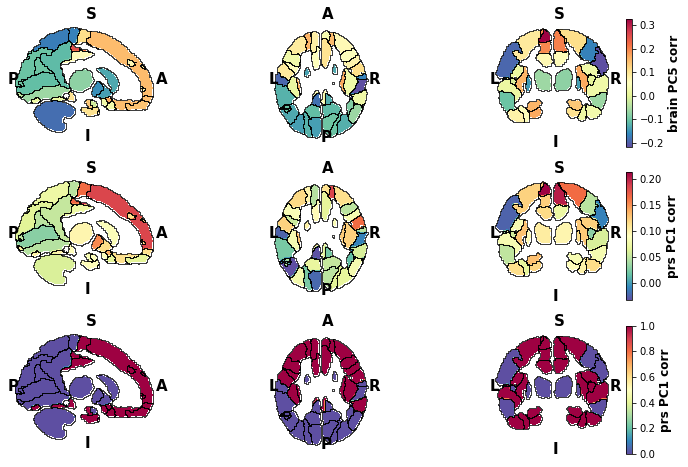

In [138]:
plot_labels = [int(i.replace('AAL ','')) for i in brain_loading_matrix.index]
brain_plot_value_values = brain_loading_matrix.values
brain_plot_values = dict(zip(plot_labels,brain_plot_value_values)) 

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 


cluster_plot_value_values = kmeans_clusters.cluster.values
cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

fig,ax = plt.subplots(3,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=brain_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[0],
    fig=fig,
    cb_title='brain PC5 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[1],
    fig=fig,
    cb_title='prs PC1 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=cluster_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[2],
    fig=fig,
    cb_title='prs PC1 corr')
# fig.savefig('./brain_plots.png')

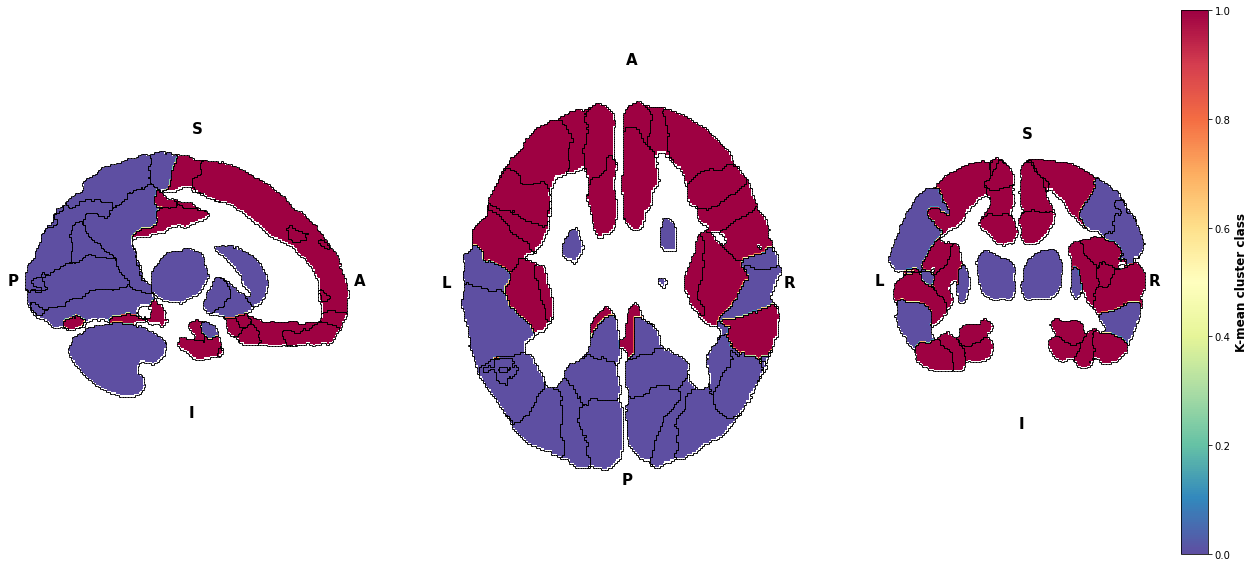

In [219]:
plot_labels = [int(i.replace('AAL ','')) for i in brain_loading_matrix.index]

cluster_plot_value_values = kmeans_clusters.cluster.values
cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=cluster_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    fig=fig,
    cb_title='K-mean cluster class')

In [363]:
ROIs_coord_AAL = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/KANA0.53_in_extdhcp40wk.nii.gz')

In [102]:
standardized_ROIs_coord = ROIs_coord_AAL.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(ROIs_coord_AAL[['X','Y','Z']])

In [103]:
standardized_ROIs_coord[standardized_ROIs_coord['Y']<0]
posterior_labels = standardized_ROIs_coord.loc[standardized_ROIs_coord['Y']<=0,'Label'].to_list()
anterior_labels = standardized_ROIs_coord.loc[standardized_ROIs_coord['Y']>0,'Label'].to_list()

In [104]:
df['Anterior_volumes'] = df[[f'AAL {int(i)}' for i in anterior_labels if f'AAL {int(i)}' in df.columns]].sum(axis=1)
df['Posterior_volumes'] = df[[f'AAL {int(i)}' for i in posterior_labels  if f'AAL {int(i)}' in df.columns]].sum(axis=1)

In [220]:
cluster_0_labels = kmeans_clusters[kmeans_clusters['cluster']==0].index.tolist()
cluster_1_labels = kmeans_clusters[kmeans_clusters['cluster']==1].index.tolist()

In [221]:
df['cluster1_volume'] = df[cluster_1_labels].sum(axis=1)
df['cluster0_volume'] = df[cluster_0_labels].sum(axis=1)

In [105]:
_, clusters_mass_univariate = data_exploration.MassUnivariate.mass_univariate(df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol','PRS_pca',
                                                                           '17 TOTAL BRAIN TISSUE VOLUME (mm3)']+ancestry,
                                                  dependentVar_cols=['Anterior_volumes','Posterior_volumes'],
                                                                       scaling='both')

In [230]:
clusters_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,
                                                                                                                thresholds=prs_labels,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol',
                                                                           '17 TOTAL BRAIN TISSUE VOLUME (mm3)']+ancestry,
                                                  dependentVar_cols=['cluster0_volume','cluster1_volume','Anterior_volumes','Posterior_volumes'],
                                                                       scaling='both')

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 34.41it/s]


In [107]:
clusters_mass_univariate.sort_values(by='PRS_pca_pval')

,const_coef,const_pval,PMA_vol_coef,PMA_vol_pval,GA_vol_coef,GA_vol_pval,PRS_pca_coef,PRS_pca_pval,17 TOTAL BRAIN TISSUE VOLUME (mm3)_coef,17 TOTAL BRAIN TISSUE VOLUME (mm3)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Gender_2.0_coef,Gender_2.0_pval
Anterior_volumes,-0.035503,0.076785,-0.005271,0.845412,-0.030009,0.098628,0.039611,0.005178,0.987410,8.886430e-112,0.021773,0.128477,-0.031000,0.028936,0.007661,0.591769,0.074373,0.016301
Posterior_volumes,-0.032415,0.057425,0.085683,0.000237,0.004714,0.759504,-0.026616,0.026615,0.929816,4.207554e-121,-0.012460,0.305403,0.006325,0.598237,-0.017107,0.159626,0.067904,0.009937


<AxesSubplot:xlabel='Adj. PRS_pca', ylabel='Adj. Total Cluster 1 volumes'>

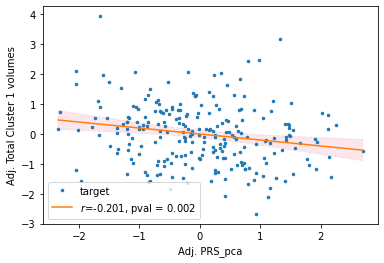

In [172]:
visualisation.simple_plots.plot_Linear_Reg(x='PRS_pca',
                                          y='cluster0_volume',data=df,adjust_covar={'x':ancestry,
                                                                                   'y':['PMA_vol','GA_vol','17 TOTAL BRAIN TISSUE VOLUME (mm3)']},markersize=5,legend_loc='inside',ylabel='Total Cluster 1 volumes')

<AxesSubplot:xlabel='Adj. PRS_pca', ylabel='Adj. cluster1_volume'>

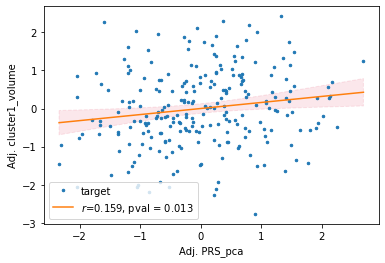

In [168]:
visualisation.simple_plots.plot_Linear_Reg(x='PRS_pca',
                                          y='cluster1_volume',data=df,adjust_covar={'x':ancestry,
                                                                                   'y':['PMA_vol','GA_vol','17 TOTAL BRAIN TISSUE VOLUME (mm3)']},markersize=5,legend_loc='inside')

In [229]:
adjusted_PRS = df

['AAL 1',
 'AAL 2',
 'AAL 3',
 'AAL 4',
 'AAL 5',
 'AAL 6',
 'AAL 7',
 'AAL 8',
 'AAL 9',
 'AAL 10',
 'AAL 11',
 'AAL 12',
 'AAL 13',
 'AAL 14',
 'AAL 15',
 'AAL 16',
 'AAL 17',
 'AAL 18',
 'AAL 19',
 'AAL 20',
 'AAL 22',
 'AAL 23',
 'AAL 24',
 'AAL 25',
 'AAL 26',
 'AAL 27',
 'AAL 28',
 'AAL 29',
 'AAL 30',
 'AAL 31',
 'AAL 32',
 'AAL 33',
 'AAL 34',
 'AAL 37',
 'AAL 38',
 'AAL 39',
 'AAL 40',
 'AAL 41',
 'AAL 55',
 'AAL 56',
 'AAL 69',
 'AAL 70',
 'AAL 80',
 'AAL 81',
 'AAL 82',
 'AAL 83',
 'AAL 84',
 'AAL 87',
 'AAL 88',
 'AAL 89',
 'AAL 90']

### Imperial atlas

In [67]:
df['Frontal_lobe'] = frontal_lobe.sum(axis=1)
df['Occipital_lobe'] = occipital_lobe.sum(axis=1)
df['Parietal_lobe'] = parietal_lobe.sum(axis=1)
df['Temporal_lobe'] = temporal_lobe.sum(axis=1)
df['Fronto_temporal_lobe'] = df['Frontal_lobe'] + df['Temporal_lobe']
df['Occipito_parietal_lobe'] = df['Occipital_lobe'] + df['Parietal_lobe']

In [68]:
Imperial_cols = [i for i in df.columns if re.search('Imperial \d',i) and i in cor_labels]
prs_labels = [i for i in df.columns if 'euro_ld_no_dups_gen' in i]


_, prs_pca, prs_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df,
                                                              dependentVar_cols=prs_labels,n_components=1,scaling=True)
pca, X_pca, brain_loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=Imperial_cols,
    scaling=True,n_components = .8)

# df['Brain_PC5'] = X_pca[:,4]
df['PRS_pca'] = prs_pca

In [77]:
test = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=prs_labels,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=[
        'GA_vol', 'PMA_vol', 'Intracranial_Imperial',
        'Total_Brain_Volume_Imperial'
    ] + ancestry,
    dependentVar_cols=['Fronto_temporal_lobe', 'Occipito_parietal_lobe'],
    scaling='both')

100%|████████████████████████| 11/11 [00:00<00:00, 43.88it/s]


In [87]:
test.sort_values(by='PRS_pval')[['Connection','PRS_coef','PRS_pval','threshold']]

,Connection,PRS_coef,PRS_pval,threshold
14,Fronto_temporal_lobe,0.032752,0.000352,euro_ld_no_dups_genPt_0.05
15,Occipito_parietal_lobe,-0.048075,0.000648,euro_ld_no_dups_genPt_0.05
11,Occipito_parietal_lobe,-0.045443,0.001191,euro_ld_no_dups_genPt_0.001
13,Occipito_parietal_lobe,-0.043263,0.002102,euro_ld_no_dups_genPt_0.01
16,Fronto_temporal_lobe,0.027079,0.003213,euro_ld_no_dups_genPt_0.1
12,Fronto_temporal_lobe,0.026323,0.004097,euro_ld_no_dups_genPt_0.01
10,Fronto_temporal_lobe,0.026068,0.004392,euro_ld_no_dups_genPt_0.001
8,Fronto_temporal_lobe,0.026139,0.005438,euro_ld_no_dups_genPt_0.0001
21,Occipito_parietal_lobe,-0.037719,0.008258,euro_ld_no_dups_genPt_1
9,Occipito_parietal_lobe,-0.037776,0.008978,euro_ld_no_dups_genPt_0.0001


In [88]:
0.05/4/6

0.0020833333333333333

In [45]:
prs_loading_matrix = df[[
    i for i in cor_labels if bool(re.search('Imperial \d', i))
]].apply(lambda x: np.corrcoef(x.values, prs_pca[:,0])[0, 1], axis=0)

brain_loading_matrix = df[[
    i for i in cor_labels if bool(re.search('Imperial \d', i))
]].apply(lambda x: np.corrcoef(x.values, X_pca[:,4])[0, 1], axis=0)

In [19]:
ROIs_coord_Imperial = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/Imperial/atlas_t40.nii.gz')

ROIs_coord_Imperial['Label'] = [f'Imperial {int(i)}' for i in ROIs_coord_Imperial['Label']]

In [20]:
new_ROIs_coord_Imperial = ROIs_coord_Imperial.set_index('Label').T.copy()
new_ROIs_coord_Imperial = data_preprocessing.Volumes.Group_Imperial_volumes(new_ROIs_coord_Imperial,grouping='segmented',operation='mean',remove_duplicated=False).T
new_ROIs_coord_Imperial = new_ROIs_coord_Imperial.drop([i for i in new_ROIs_coord_Imperial.index if not bool(re.search('Imperial \d',i))])

In [21]:
standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X','Y','Z']])

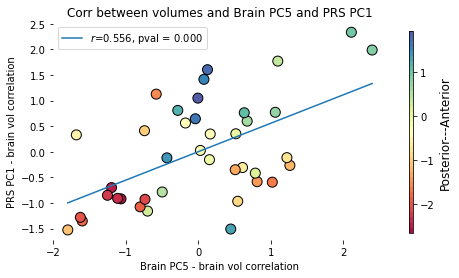

In [22]:
visualisation.simple_plots.Scatter(y=prs_loading_matrix,
                                   x=brain_loading_matrix,
                                   colorby=standardized_ROIs_coord.loc[prs_loading_matrix.index,'Y'],
                                  markersize=100,legend_loc='upper left',colorbar_label='Posterior---Anterior',
                                  cmap='Spectral',hide_CI=True,title='Corr between volumes and Brain PC5 and PRS PC1',
                                  xlabel='Brain PC5 - brain vol correlation',
                                  ylabel='PRS PC1 - brain vol correlation',edgecolors='k')
sns.despine(bottom=True,left=True)

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [147]:
corr_matrices = np.concatenate([prs_loading_matrix.values.reshape(-1,1),
               brain_loading_matrix.values.reshape(-1,1)],axis=1)

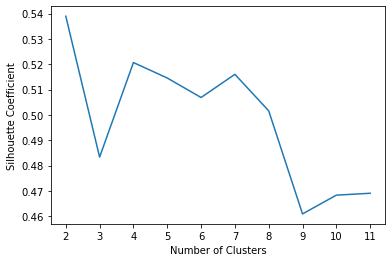

In [148]:
kmeans_kwargs= {
    "init":"random",
    "n_init":12,
    "max_iter":300,
    "random_state":42
}
silhouette_coefficients = []
for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(corr_matrices)
    score = silhouette_score(corr_matrices, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score


plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [149]:
n_clusters=2
kmeans = KMeans(
    init="random",
    n_clusters=n_clusters,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(corr_matrices)

KMeans(init='random', n_clusters=2, random_state=42)

In [150]:
kmeans_clusters = pd.DataFrame({'PRS-cor':prs_loading_matrix,
            'Brain-cor':brain_loading_matrix,
             'cluster':kmeans.predict(corr_matrices)})

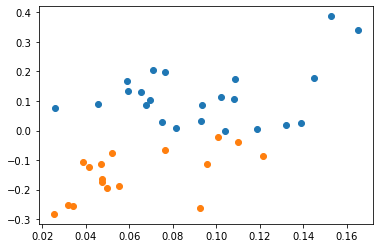

In [151]:
for i in range(5):
    plt.scatter(kmeans_clusters.loc[kmeans_clusters['cluster']==i,'PRS-cor'],
            kmeans_clusters.loc[kmeans_clusters['cluster']==i,'Brain-cor'])

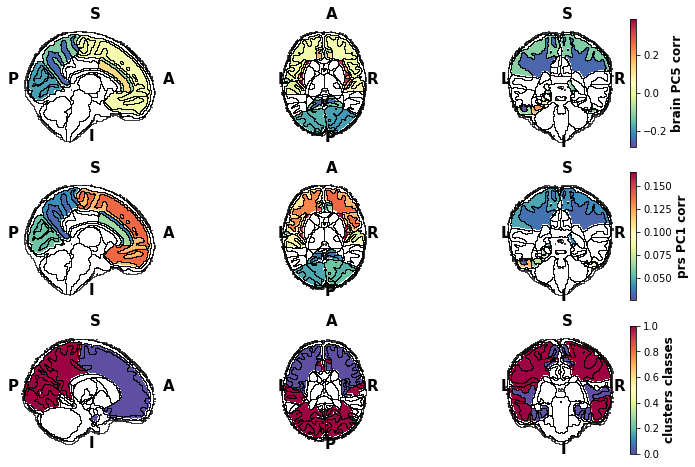

In [152]:
plot_labels = [int(i.replace('Imperial ','')) for i in brain_loading_matrix.index]
brain_plot_value_values = brain_loading_matrix.values
brain_plot_values = dict(zip(plot_labels,brain_plot_value_values)) 

prs_plot_value_values = prs_loading_matrix.values
prs_plot_values = dict(zip(plot_labels,prs_plot_value_values)) 


cluster_plot_value_values = kmeans_clusters.cluster.values
cluster_plot_values = dict(zip(plot_labels,cluster_plot_value_values)) 

fig,ax = plt.subplots(3,3,figsize=(12,8))
_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=brain_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[0],
    fig=fig,
    cb_title='brain PC5 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
#     atlas_slice=120,
    plot_values=prs_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[1],
    fig=fig,
    cb_title='prs PC1 corr')

_, map_view_dict = visualisation.Brainmap.plot_segmentation(
    map_view=['sagittal', 'axial', 'coronal'],
    atlas_slice=120,
    plot_values=cluster_plot_values,
    colorbar=True,
    atlas_file='../../dataset/visualise/Imperial/atlas_t40.nii.gz',
    cb_orientation='vertical',
    cmap_reversed=True,
    axes=ax[2],
    fig=fig,
    cb_title='clusters classes')

# fig.savefig('./brain_plots.png')

In [153]:
standardized_ROIs_coord = new_ROIs_coord_Imperial.copy()
standardized_ROIs_coord[['X','Y','Z']] = StandardScaler().fit_transform(new_ROIs_coord_Imperial[['X','Y','Z']])

In [154]:
posterior_labels = standardized_ROIs_coord[standardized_ROIs_coord['Y']<=0].index.to_list()
anterior_labels = standardized_ROIs_coord[standardized_ROIs_coord['Y']>0].index.to_list()

In [155]:
df['Anterior_volumes'] = df[[i for i in anterior_labels if i in Imperial_cols]].sum(axis=1)
df['Posterior_volumes'] = df[[i for i in posterior_labels if i in Imperial_cols]].sum(axis=1)

In [156]:
cluster_0_labels = kmeans_clusters[kmeans_clusters['cluster']==0].index.tolist()
cluster_1_labels = kmeans_clusters[kmeans_clusters['cluster']==1].index.tolist()

In [157]:
df['cluster1_volume'] = df[cluster_1_labels].sum(axis=1)
df['cluster0_volume'] = df[cluster_0_labels].sum(axis=1)

In [158]:
_, clusters_mass_univariate = data_exploration.MassUnivariate.mass_univariate(df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['PMA_vol','GA_vol','PRS_pca',
                                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']+ancestry,
                                                  dependentVar_cols=['cluster0_volume','cluster1_volume',
                                                                     'Anterior_volumes','Posterior_volumes'],
                                                                       scaling='both')

In [159]:
clusters_mass_univariate

,const_coef,const_pval,PMA_vol_coef,PMA_vol_pval,GA_vol_coef,GA_vol_pval,PRS_pca_coef,PRS_pca_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,Total_Brain_Volume_Imperial_coef,Total_Brain_Volume_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Gender_2.0_coef,Gender_2.0_pval
cluster0_volume,-0.002664,0.869664,-0.120563,9.445230e-08,0.002096,0.886246,0.037592,0.001098,0.000346,0.994559,1.060683,1.544160e-53,0.018147,0.117313,-0.020115,0.079372,0.018055,0.118892,0.005581,0.823899
cluster1_volume,0.016790,0.308265,0.003479,8.754875e-01,0.015858,0.286330,-0.036733,0.001639,0.028626,0.577458,0.952310,5.188621e-46,-0.012933,0.270239,0.017594,0.129768,-0.010659,0.362936,-0.035171,0.167421
Anterior_volumes,-0.007331,0.661283,-0.115542,6.203962e-07,0.004371,0.772176,0.038241,0.001264,0.057415,0.272000,1.001898,4.353106e-48,0.017185,0.149783,-0.017759,0.132380,0.017200,0.149117,0.015356,0.552431
Posterior_volumes,0.019373,0.199424,-0.008815,6.645960e-01,0.013125,0.335021,-0.032452,0.002362,-0.019948,0.671514,1.010044,3.226983e-55,-0.010126,0.345600,0.013218,0.213434,-0.008091,0.450591,-0.040582,0.082256


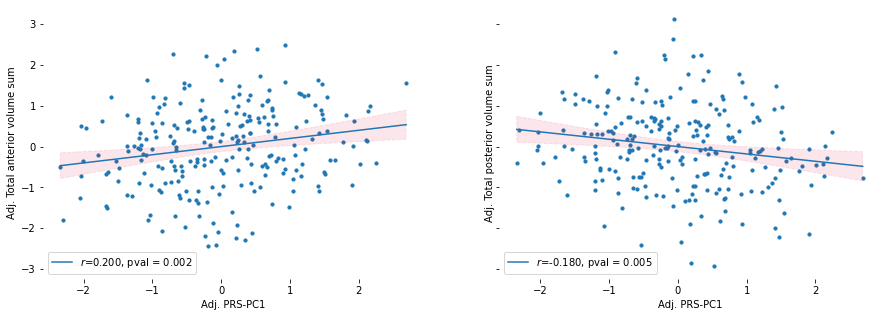

In [160]:
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Anterior_volumes',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total anterior volume sum',
                                  ax=ax[0],legend_loc='lower left')

visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='Posterior_volumes',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total posterior volume sum',
                                  ax=ax[1],legend_loc='lower left')
sns.despine(bottom=True,left=True)

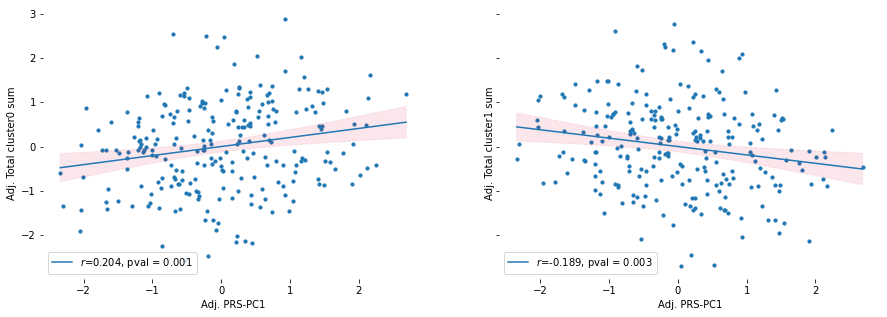

In [161]:
fig,ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='cluster0_volume',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total cluster0 sum',
                                  ax=ax[0],legend_loc='lower left')

visualisation.simple_plots.Scatter(x='PRS_pca',
                                  y='cluster1_volume',
                                  data=df,adjust_covar={'x':ancestry,
                                                       'y':['PMA_vol','GA_vol',    
                                                           'Intracranial_Imperial','Total_Brain_Volume_Imperial']},
                                  markersize=10,
                                   xlabel='PRS-PC1',
                                  ylabel='Total cluster1 sum',
                                  ax=ax[1],legend_loc='lower left')
sns.despine(bottom=True,left=True)

In [162]:
cluster_1_labels

['Imperial 5',
 'Imperial 6',
 'Imperial 11',
 'Imperial 13',
 'Imperial 14',
 'Imperial 22',
 'Imperial 23',
 'Imperial 32',
 'Imperial 33',
 'Imperial 38',
 'Imperial 39',
 'Imperial 59',
 'Imperial 60',
 'Imperial 65',
 'Imperial 66',
 'Imperial 81',
 'Imperial 82']

In [163]:
cluster_0_labels

['Imperial 9',
 'Imperial 10',
 'Imperial 12',
 'Imperial 15',
 'Imperial 16',
 'Imperial 20',
 'Imperial 21',
 'Imperial 36',
 'Imperial 37',
 'Imperial 51',
 'Imperial 52',
 'Imperial 55',
 'Imperial 56',
 'Imperial 57',
 'Imperial 58',
 'Imperial 61',
 'Imperial 62',
 'Imperial 63',
 'Imperial 64',
 'Imperial 75',
 'Imperial 76',
 'Imperial 79',
 'Imperial 80']